# Import

In [ ]:
import zipfile
import os
from collections import Counter
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
import numpy as np
from collections import Counter
import torch
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from torch.optim import AdamW
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Reading Data

In [ ]:
zip_path = "/content/Teeth_Dataset.zip"
extract_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir("/content/"))

['.config', 'final_model.pth', 'Teeth_classification', 'Teeth_Dataset', 'Teeth_Dataset.zip', 'sample_data']


# Exploring Data

In [ ]:
data_dir = "/content/Teeth_Dataset"

for split in ["Training", "Validation", "Testing"]:
    split_path = os.path.join(data_dir, split)
    print(f"\n{split.upper()} SET:")
    print(os.listdir(split_path))



TRAINING SET:
['CoS', 'MC', 'Gum', 'OT', 'OLP', 'OC', 'CaS']

VALIDATION SET:
['CoS', 'MC', 'Gum', 'OT', 'OLP', 'OC', 'CaS']

TESTING SET:
['CoS', 'MC', 'Gum', 'OT', 'OLP', 'OC', 'CaS']


In [ ]:
def count_images(split_path):
    counts = {}
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len(os.listdir(cls_path))
    return counts

for split in ["Training", "Validation", "Testing"]:
    split_path = os.path.join(data_dir, split)
    counts = count_images(split_path)
    print(f"\n{split.upper()} counts:")
    print(counts)



TRAINING counts:
{'CoS': 450, 'MC': 540, 'Gum': 360, 'OT': 393, 'OLP': 540, 'OC': 324, 'CaS': 480}

VALIDATION counts:
{'CoS': 149, 'MC': 180, 'Gum': 120, 'OT': 131, 'OLP': 180, 'OC': 108, 'CaS': 160}

TESTING counts:
{'CoS': 149, 'MC': 180, 'Gum': 120, 'OT': 131, 'OLP': 180, 'OC': 108, 'CaS': 160}


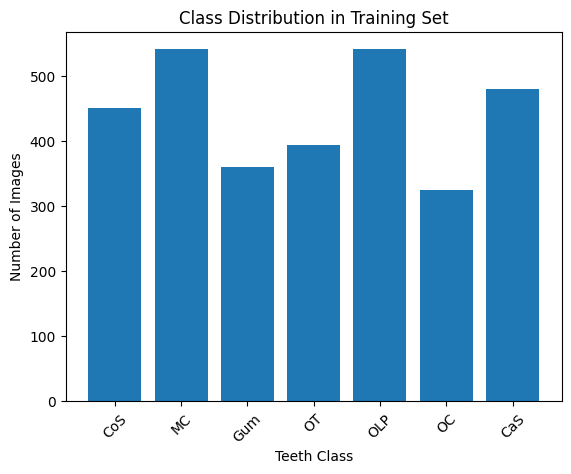

In [ ]:
train_counts = count_images(os.path.join(data_dir, "Training"))

plt.bar(train_counts.keys(), train_counts.values())
plt.title("Class Distribution in Training Set")
plt.xlabel("Teeth Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


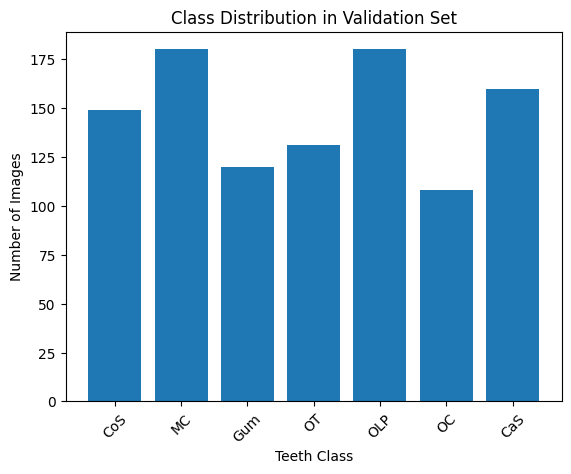

In [ ]:
train_counts = count_images(os.path.join(data_dir, "Validation"))

plt.bar(train_counts.keys(), train_counts.values())
plt.title("Class Distribution in Validation Set")
plt.xlabel("Teeth Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


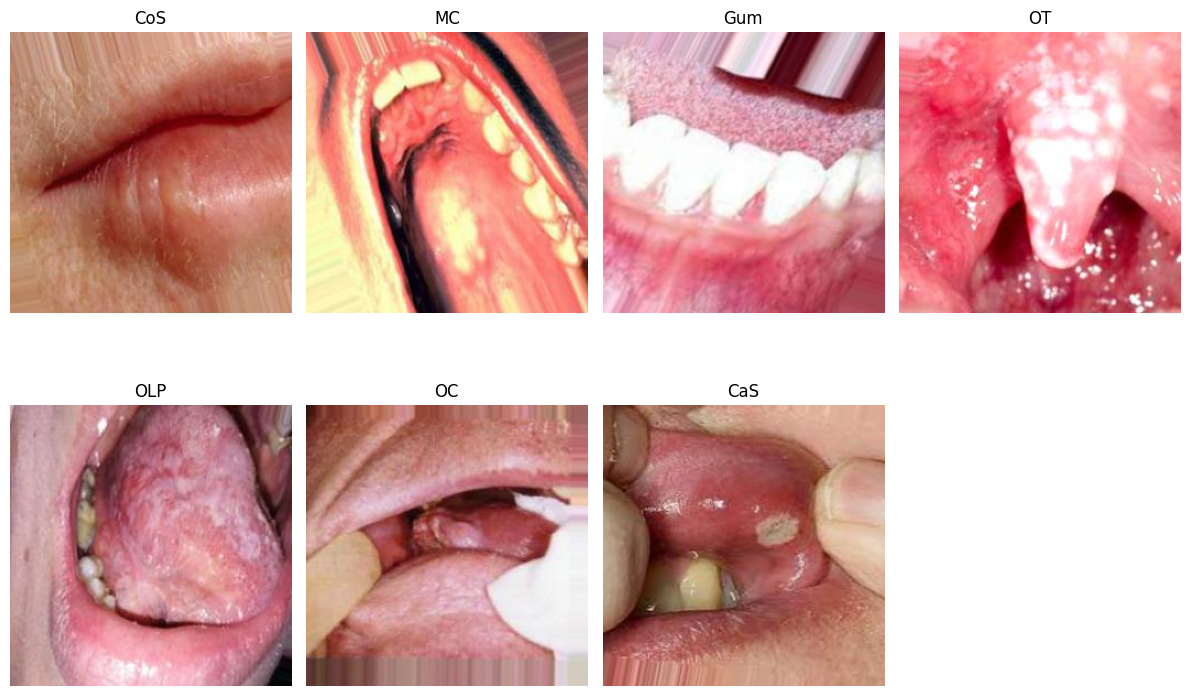

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_path = os.path.join(data_dir, "Training")

classes = os.listdir(train_path)

plt.figure(figsize=(12, 8))
for i, cls in enumerate(classes[:7]):  # limit to 7 classes
    cls_folder = os.path.join(train_path, cls)
    img_file = random.choice(os.listdir(cls_folder))
    img_path = os.path.join(cls_folder, img_file)

    img = mpimg.imread(img_path)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()


# Preprocessing

In [ ]:
IMG_SIZE = 224

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),

])

train_dir = "/content/Teeth_Dataset/Training"
val_dir   = "/content/Teeth_Dataset/Validation"

train_ds = datasets.ImageFolder(root=train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(root=val_dir,   transform=val_tfms)

print("Detected mapping:", train_ds.class_to_idx)
assert train_ds.class_to_idx == val_ds.class_to_idx, "Train/Val mappings differ!"

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)

# idx_to_class for decoding predictions later:
idx_to_class = {v:k for k,v in train_ds.class_to_idx.items()}
print("idx_to_class:", idx_to_class)


Detected mapping: {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
idx_to_class: {0: 'CaS', 1: 'CoS', 2: 'Gum', 3: 'MC', 4: 'OC', 5: 'OLP', 6: 'OT'}


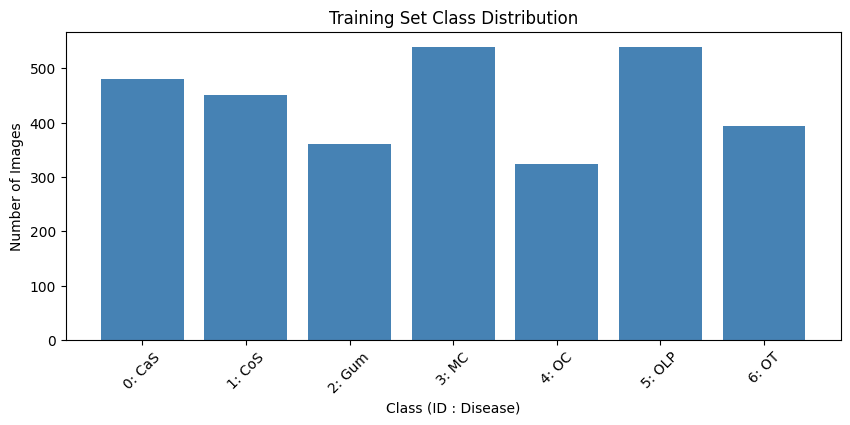

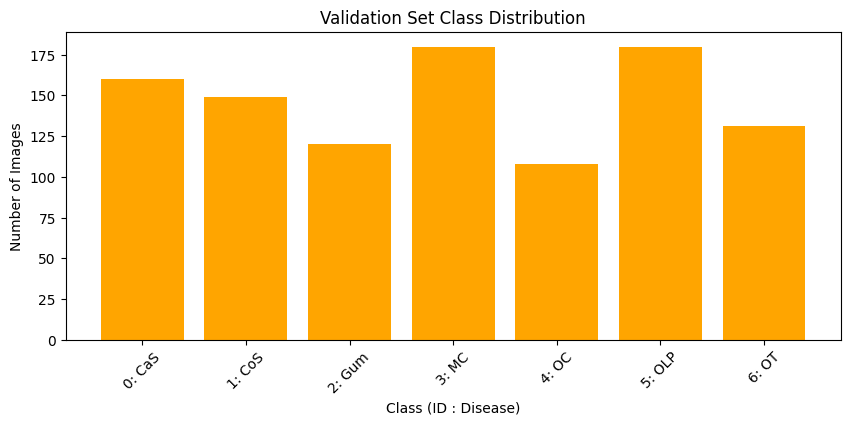

In [ ]:

train_counts = Counter(train_ds.targets)
val_counts   = Counter(val_ds.targets)


idx_to_class = {v: k for k, v in train_ds.class_to_idx.items()}


train_labels = [f"{i}: {idx_to_class[i]}" for i in sorted(train_counts.keys())]
train_values = [train_counts[i] for i in sorted(train_counts.keys())]


val_labels = [f"{i}: {idx_to_class[i]}" for i in sorted(val_counts.keys())]
val_values = [val_counts[i] for i in sorted(val_counts.keys())]


plt.figure(figsize=(10,4))
plt.bar(train_labels, train_values, color="steelblue")
plt.title("Training Set Class Distribution")
plt.xlabel("Class (ID : Disease)")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(10,4))
plt.bar(val_labels, val_values, color="orange")
plt.title("Validation Set Class Distribution")
plt.xlabel("Class (ID : Disease)")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


In [ ]:
train_counts = Counter(train_ds.targets)
num_classes  = len(train_ds.classes)
max_count    = max(train_counts.values())
print("Per-class counts:", {i: train_counts[i] for i in range(num_classes)})
print("Max count:", max_count)


Per-class counts: {0: 480, 1: 450, 2: 360, 3: 540, 4: 324, 5: 540, 6: 393}
Max count: 540


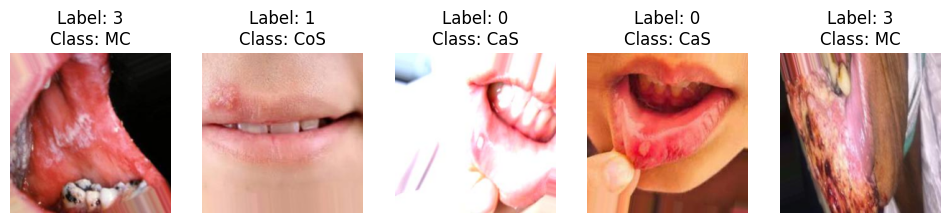

In [ ]:
def show_random_samples(dataset, n=5):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        idx = random.randint(0, len(dataset)-1)
        img, label = dataset[idx]

        plt.subplot(1, n, i+1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Label: {label}\nClass: {dataset.classes[label]}")
        plt.axis("off")
    plt.show()

show_random_samples(train_ds, n=5)


In [ ]:
IMG_SIZE = 224

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])


train_augment = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.20, contrast=0.20, saturation=0.20, hue=0.10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

train_dir = "/content/Teeth_Dataset/Training"
val_dir   = "/content/Teeth_Dataset/Validation"

train_ds_base = datasets.ImageFolder(root=train_dir, transform=train_preprocess)
train_ds_aug  = datasets.ImageFolder(root=train_dir, transform=train_augment)
val_ds        = datasets.ImageFolder(root=val_dir,   transform=val_tfms)

print("Detected mapping:", train_ds_base.class_to_idx)
assert train_ds_base.class_to_idx == val_ds.class_to_idx, "Train/Val mappings differ!"
idx_to_class = {v:k for k,v in train_ds_base.class_to_idx.items()}

train_counts = Counter(train_ds_base.targets)
num_classes  = len(train_ds_base.classes)
max_count    = max(train_counts.values())
print("Original train counts:", {i: train_counts[i] for i in range(num_classes)})
print("Target (max) per class:", max_count)

rng = np.random.default_rng(42)
indices_by_class = {c: [] for c in range(num_classes)}
for idx, (_, y) in enumerate(train_ds_base.samples):
    indices_by_class[y].append(idx)

aug_indices = []
for c in range(num_classes):
    need = max_count - len(indices_by_class[c])
    if need > 0:
        picked = rng.choice(indices_by_class[c], size=need, replace=True).tolist()
        aug_indices.extend(picked)

train_ds_aug_subset = Subset(train_ds_aug, aug_indices)

train_ds_balanced = ConcatDataset([train_ds_base, train_ds_aug_subset])

# DataLoaders
train_loader = DataLoader(train_ds_balanced, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,           batch_size=32, shuffle=False, num_workers=2)

print("idx_to_class:", idx_to_class)


Detected mapping: {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
Original train counts: {0: 480, 1: 450, 2: 360, 3: 540, 4: 324, 5: 540, 6: 393}
Target (max) per class: 540
idx_to_class: {0: 'CaS', 1: 'CoS', 2: 'Gum', 3: 'MC', 4: 'OC', 5: 'OLP', 6: 'OT'}


In [ ]:
balanced_labels = Counter()

for ds_idx in range(len(train_ds_balanced)):
    _, y = train_ds_balanced[ds_idx]
    balanced_labels[y] += 1

print("Balanced counts:", {idx_to_class[k]: v for k, v in sorted(balanced_labels.items())})


Balanced counts: {'CaS': 540, 'CoS': 540, 'Gum': 540, 'MC': 540, 'OC': 540, 'OLP': 540, 'OT': 540}


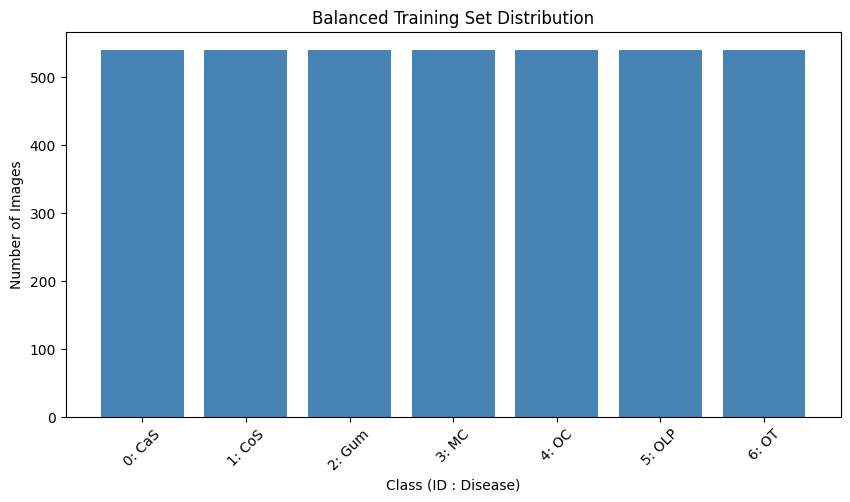

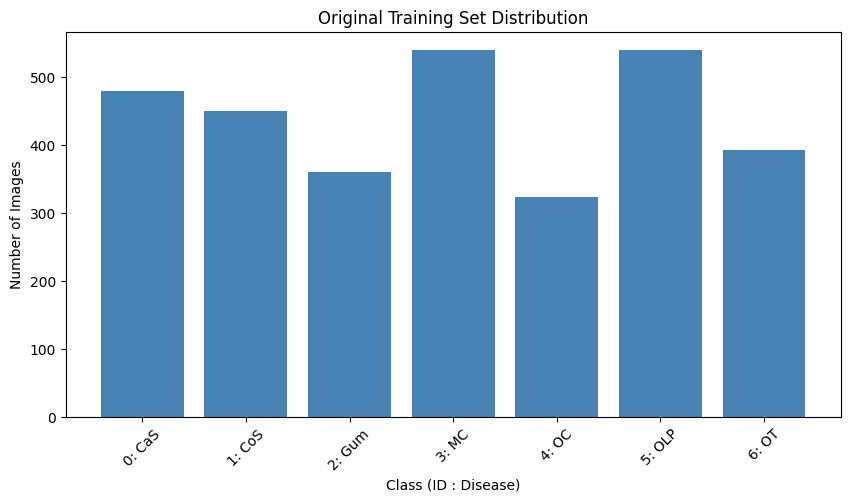

In [ ]:
def plot_class_distribution(dataset, idx_to_class, title="Class Distribution"):

    counts = Counter()
    for _, label in dataset:
        counts[label] += 1

    labels = [f"{i}: {idx_to_class[i]}" for i in sorted(counts.keys())]
    values = [counts[i] for i in sorted(counts.keys())]

    # Plot
    plt.figure(figsize=(10,5))
    plt.bar(labels, values, color="steelblue")
    plt.title(title)
    plt.xlabel("Class (ID : Disease)")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_ds_balanced, idx_to_class, title="Balanced Training Set Distribution")
plot_class_distribution(train_ds_base, idx_to_class, title="Original Training Set Distribution")


# Model

In [ ]:


def conv_bn_relu(in_c, out_c, k=3, p=1):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, k, padding=p, bias=False),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
    )

class VGG16(nn.Module):

    def __init__(self, num_classes=7, init_weights=True,
                 block_dropout=0.15, head_dropout=0.3):
        super().__init__()
        self.block1 = nn.Sequential(
            conv_bn_relu(3, 64),
            conv_bn_relu(64, 64),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(block_dropout),
        )
        self.block2 = nn.Sequential(
            conv_bn_relu(64, 128),
            conv_bn_relu(128, 128),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(block_dropout),
        )
        self.block3 = nn.Sequential(
            conv_bn_relu(128, 256),
            conv_bn_relu(256, 256),
            conv_bn_relu(256, 256),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(block_dropout),
        )
        self.block4 = nn.Sequential(
            conv_bn_relu(256, 512),
            conv_bn_relu(512, 512),
            conv_bn_relu(512, 512),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(block_dropout),
        )

        self.gap = nn.AdaptiveAvgPool2d(1)


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(head_dropout),
            nn.Linear(512, num_classes),
        )

        if init_weights:
            self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x


model = VGG16(num_classes=7)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

@torch.no_grad()
def evaluate(model, loader, amp=True):
    model.eval()
    total_loss, total_acc, total_n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=(amp and device.type == "cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        bs = y.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, y) * bs
        total_n    += bs
    return total_loss / total_n, total_acc / total_n

def train_one_epoch(model, loader, optimizer, amp=True):
    model.train()
    total_loss, total_acc, total_n = 0.0, 0.0, 0
    scaler = torch.cuda.amp.GradScaler(enabled=(amp and device.type == "cuda"))
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=(amp and device.type == "cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        if scaler.is_enabled():
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        bs = y.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, y) * bs
        total_n    += bs
    return total_loss / total_n, total_acc / total_n


EPOCHS = 50
PATIENCE_ACC = 4
amp = True

best_val_acc = 0.0
epochs_no_improve = 0
best_epoch = -1
start_time = time()

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, amp=amp)
    val_loss, val_acc = evaluate(model, val_loader, amp=amp)

    improved = val_acc > best_val_acc + 1e-6
    if improved:
        best_val_acc = val_acc
        best_epoch = epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f}  train_acc={tr_acc:.4f}  "
          f"val_loss={val_loss:.4f}  val_acc={val_acc:.4f}  "
          f"(no_improve={epochs_no_improve}/{PATIENCE_ACC})")

    if epochs_no_improve >= PATIENCE_ACC:
        print(f"Early stopping at epoch {epoch} (no val_acc improvement for {PATIENCE_ACC} epochs).")
        break

elapsed = time() - start_time
print(f"Finished. Best epoch = {best_epoch}, best val_acc = {best_val_acc:.4f}.")


/tmp/ipython-input-3407406426.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(amp and device.type == "cuda"))


[01/50] train_loss=1.8696  train_acc=0.2913  val_loss=1.6260  val_acc=0.3473  (no_improve=0/4)
[02/50] train_loss=1.6509  train_acc=0.3677  val_loss=1.5845  val_acc=0.4056  (no_improve=0/4)
[03/50] train_loss=1.5680  train_acc=0.3833  val_loss=1.5775  val_acc=0.3765  (no_improve=1/4)
[04/50] train_loss=1.5063  train_acc=0.4196  val_loss=1.4423  val_acc=0.4368  (no_improve=0/4)
[05/50] train_loss=1.4479  train_acc=0.4333  val_loss=1.3276  val_acc=0.4854  (no_improve=0/4)
[06/50] train_loss=1.3844  train_acc=0.4749  val_loss=1.2698  val_acc=0.5272  (no_improve=0/4)
[07/50] train_loss=1.3702  train_acc=0.4741  val_loss=1.2709  val_acc=0.5243  (no_improve=1/4)
[08/50] train_loss=1.2903  train_acc=0.5146  val_loss=1.1597  val_acc=0.5535  (no_improve=0/4)
[09/50] train_loss=1.2295  train_acc=0.5296  val_loss=1.1876  val_acc=0.5671  (no_improve=0/4)
[10/50] train_loss=1.1819  train_acc=0.5579  val_loss=1.0667  val_acc=0.5953  (no_improve=0/4)
[11/50] train_loss=1.1568  train_acc=0.5635  val_l

In [ ]:
torch.save(model.state_dict(), "final_model.pth")

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd

IMG_SIZE = 224
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# Test transforms (same as val)
test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

test_dir = "/content/Teeth_Dataset/Testing"

# Labeled test set (class subfolders)
test_ds = datasets.ImageFolder(root=test_dir, transform=test_tfms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Class mapping
idx_to_class = {v: k for k, v in test_ds.class_to_idx.items()}

# Inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

all_paths, all_preds, all_probs, all_targets = [], [], [], []

with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        start = i * test_loader.batch_size
        end   = start + x.size(0)
        batch_paths = [test_ds.samples[j][0] for j in range(start, end)]

        x = x.to(device, non_blocking=True)
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        preds = probs.argmax(dim=1).cpu()

        all_paths.extend(batch_paths)
        all_probs.extend(probs.cpu().tolist())
        all_preds.extend(preds.tolist())
        all_targets.extend(y.tolist())

test_acc = (torch.tensor(all_preds) == torch.tensor(all_targets)).float().mean().item()
print(f"Test accuracy: {test_acc:.4f}")

pred_labels = [idx_to_class[i] for i in all_preds]
true_labels = [idx_to_class[i] for i in all_targets]
top_probs   = [max(p) for p in all_probs]

df = pd.DataFrame({
    "path": all_paths,
    "true_label": true_labels,
    "pred_label": pred_labels,
    "pred_confidence": top_probs,
})
csv_path = "/content/test_predictions.csv"
df.to_csv(csv_path, index=False)
print(f"Saved predictions to: {csv_path}")


Test accuracy: 0.9523
Saved predictions to: /content/test_predictions.csv


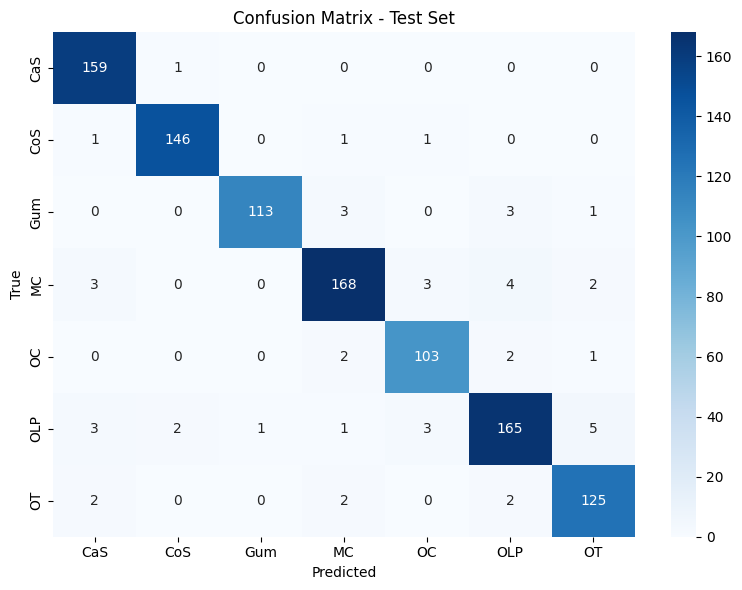


Classification Report:
              precision    recall  f1-score   support

         CaS     0.9464    0.9938    0.9695       160
         CoS     0.9799    0.9799    0.9799       149
         Gum     0.9912    0.9417    0.9658       120
          MC     0.9492    0.9333    0.9412       180
          OC     0.9364    0.9537    0.9450       108
         OLP     0.9375    0.9167    0.9270       180
          OT     0.9328    0.9542    0.9434       131

    accuracy                         0.9523      1028
   macro avg     0.9533    0.9533    0.9531      1028
weighted avg     0.9526    0.9523    0.9523      1028



In [ ]:
y_true = [idx_to_class[i] for i in all_targets]
y_pred = [idx_to_class[i] for i in all_preds]
class_names = list(idx_to_class.values())

cm = confusion_matrix(y_true, y_pred, labels=class_names)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
